# Time-Lapse Movie
This notebook shows how to make a time-lapse animation from a set of CamHD videos. This notebook relies on the scene log compiled by Friedrich Knuth and Hailey Conrad.

#### Setup your environment

In [1]:
%matplotlib inline
import pycamhd as camhd
import numpy as np
import matplotlib.pyplot as plt

#### Ingest the Rutgers scene log into a nested list

In [2]:
import requests
import csv
scene_log_url = 'https://raw.githubusercontent.com/ooi-data-review/camhd_metadata/master/scene_timing/zoom0_scenes.csv'
scene_log_page = requests.get(scene_log_url)
scene_log_content = scene_log_page.content.decode('utf-8')
scene_log_csv = csv.reader(scene_log_content.splitlines(), delimiter=',')
scene_log = list(scene_log_csv)

#### Get a list of local CamHD files to process

In [3]:
import glob
filenames = glob.glob('/data/*.mov')

#### Get a list of frame numbers to process using the log file

In [4]:
frame_numbers = []
for filename in filenames:
    for row in scene_log:
        if filename[6:32] in row[0]:
            next_frame_time = row[3].split(':') # this is the third scene
            if len(next_frame_time)==3:
                frame_time = next_frame_time
    frame_numbers.append(int(round((int(frame_time[1])*60+int(frame_time[2]))*29.95))+60)

#### Show the first image of the time-lapse and save it for the cover image

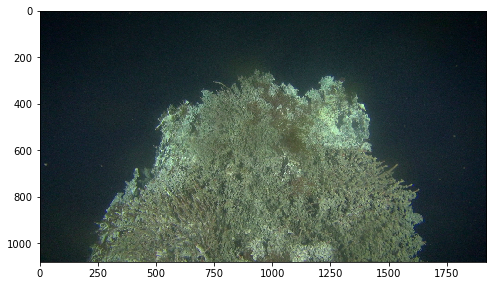

In [5]:
plt.rc('figure', figsize=(8, 8))
frame = camhd.get_frame(filenames[0], frame_numbers[0], 'rgb24')
imgplot = plt.imshow(frame)

In [6]:
from numpngw import write_png
from scipy.misc import imresize
write_png('time_lapse.png', imresize(frame, (270, 480)))

#### Loop through the file list to generate an MP4 using an FFMPEG pipe

In [7]:
%%time
import subprocess as sp
command = [ 'ffmpeg',
           '-y', #overwrite output file if it exists
           '-f', 'rawvideo',
           '-vcodec','rawvideo',
           '-s', '1920x1080', # size of input frame
           '-pix_fmt', 'rgb24',
           '-r', '30', # output frame rate
           '-i', '-', # input from pipe
           '-an', # no audio
           '-vf', 'scale=480x270',
           '-c:v', 'h264',
           '-preset', 'veryfast',
           '-crf', '18',
           '-pix_fmt', 'yuv420p',
           'time_lapse.mp4' ]

pipe = sp.Popen(command, stdin=sp.PIPE, stderr=sp.PIPE)

for i, filename in enumerate(filenames):
    frame = camhd.get_frame(filename, frame_numbers[i], 'rgb24')
    pipe.stdin.write(frame.tostring())

pipe.stdin.flush() # Ensure nothing is left in the buffer
pipe.terminate()

CPU times: user 1min 7s, sys: 2.54 s, total: 1min 9s
Wall time: 1min 11s


#### Show the video using HTML5 magic

In [8]:
%%HTML
<video width="480" height="270" controls poster="test.png">
  <source src="time_lapse.mp4" type="video/mp4">
</video>

### References

PyCamHD: https://github.com/tjcrone/pycamhd<br>
CamHDHub: https://github.com/tjcrone/camhdhub<br>
Raw Data Archive: https://rawdata.oceanobservatories.org/files/RS03ASHS/PN03B/06-CAMHDA301/<br>
CamHD Metadata: https://github.com/ooi-data-review/camhd_metadata